# Modelling

This notebook contains the main models of both iterations
Since some cells require significant computing power, they are commented and the respective model is pickled
Following the structure of the previous notebooks, the second iteration appears first, followed by the first one as a backup

**Summary**
Given the distribution of the target variable, it is deemed relevant for a model to achieve an accuracy of over 82%. However, considering the objective of optimizing retention in a cost-efficient manner, additional evaluation metrics were prioritized. These metrics include recall and specificity for the negative class (not churned) and computing power, for example, a distance based KNN yielded good results but proved to be significantly expensive to run. 

The top-performing models were Random Forest and XGBoost. While they had similar performance overall, XGBoost was chosen as the preferred model due to its computational efficiency (less depth layers) and an improvement of 200 basis points in specificity for the negative class.

The final model achieved an accuracy of 94%, recall of 98%, 94% precision. For the negative class, the model achieved a true negative ratio of 75% and a negative predicted value of 91%. These results indicate that the model effectively classifies instances, with a high rate of correctly identifying positive cases and a satisfactory rate of avoiding false negatives.

----

**Table of contents**
1. Baseline Model
2. Random Forest
    1. Random Forest optimization
3. XGBoost
    1. XGBoost optimization
4. Backup: Iteration 1
    1. Baseline model
    2. KNN
    3. Random Forest
    4. XGBoost

----

### Libraries

In [1]:
#Imports:
#General imports
import numpy as np
import pandas as pd



# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [2]:
#Imports:
#Storing the model
import joblib

In [3]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Other models
from xgboost import XGBClassifier


#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Functions

In [4]:
def nan_vis(df):
    """
    Visualizes missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - str: A message indicating if there are any missing values or not.
    - If there are missing values, returns a bar graph with the missing values.
    """

    # Visualize missing values
    if df.isna().sum().sum() == 0:
        return "There are no missing values"
    else:
        plt.figure(figsize=(10, 6))
        plt.title("Missing Values")
        ax = sns.barplot(x=df.columns, y=df.isna().sum())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.xlabel("Columns")
        plt.ylabel("Missing Values Count")
        plt.show()

In [5]:
def replace_nan_with_zero(df, columns):
    """
    Replaces the NaN values with 0

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - List columns of the DataFrame that will be removed.

    Returns:
    - df (pandas.DataFrame): The input DataFrame with the updated values
    """
    df[columns] = df[columns].fillna(0)
    return df

## Iteration 2

For this iteration, I decided to focus on Random Forest and XGBoost models, as KNN models are less accurate and more expensive to run.

After optimizing both models, both of them achieved a ROC AUC of 0.97. But  I decided to proceed with the second iteration of XGBoost.

XGBoost required less computational power, had fewer layers, and performed slightly better in predicting the negative classes as well.

### Loading the DF and splitting

In [6]:
#Loading the final DF
dfmodel = pd.read_csv('../data/elenas-it2-postpreprocessing.csv')

In [7]:
#Sanity checks: 

#Visualizing the NaN values
print(nan_vis(dfmodel))

# Target variable distribution
dfmodel["churn"].value_counts()

There are no missing values


1    38760
0     8944
Name: churn, dtype: int64

In [8]:
#Dropping non numerical values:
dfmodel.drop(["seller_created_at"], axis=1, inplace=True)

In [9]:
#Splitting the variables
X = dfmodel.drop(columns="churn")
y = dfmodel["churn"]

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

### Baseline model:

Based on the findings of the first iteration, the baseline model for this version is a decision tree with 2 layers of depth, cross-validated 5 times. 

- The accuracy is 0.88 which is higher than the values distribution so is interesting. This score was 0.88 for the train set, indicating that there is no overfitting
- The recall is 0.98, meaning that almost all the churn cases were identified by the model
- The precision is 0.88, indicating that false positives are present

In [10]:
#Fitting the baseline model
baseline_dt = DecisionTreeClassifier(max_depth=2)
baseline_cv = cross_val_score(baseline_dt, X_train, y_train, cv=5)
baseline_fitted = baseline_dt.fit(X_train, y_train)


In [11]:
#Baseline scores:

# Predict labels
y_pred = baseline_fitted.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = baseline_fitted.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.8816685881983021
- Baseline recall: 0.9872291021671826
- Baseline precision: 0.8813774041229989
- Baseline f1: 0.9313051414663827



In [12]:
#Check for overfitting
print(f"overfitting - train model score: {baseline_fitted.score(X_train, y_train)}")

overfitting - train model score: 0.882137148547022


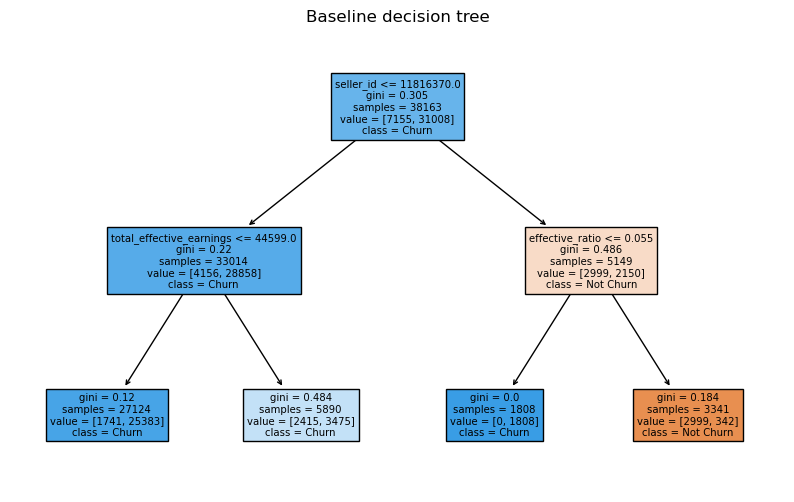

In [13]:
# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(baseline_fitted, feature_names=X_train.columns, filled=True, class_names=["Not Churn", "Churn"], impurity=True)
plt.title("Baseline decision tree")
plt.show()

### Random Forest

|  Name |Comments   |Accuracy / recall   |Parameters|
|---|---|---|---|
| Version 1: |The The model is significantly overfitting, as the train model score is 1.0|0.93 / 0.98|200 max depth(based on iteration 1), standard scaler, no PCA, 5 cross- validation|
| Version 2 |The model continues to overfit so, min samples split will be added for the next iteration with a less layers |0.94 / 0.98|Changed the range of max depth to 10, 12, 200, but the chosen parameter was 200. No PCA and no Scaler, 5 cross-validation|
| Version 3|Less overfitting but it is still relevant 5% difference of scores between test and train|0.93 / 0.98 |Max depth of 10, 12, 15, 20 with min samples of 2,4,6, 12. The chosen ones are max depth of 20, min sample split 6, Standard Scaler and no PCA, 5 cross-validation|


The ideal number of layers is 9, after that the results marginally decrease and starts to overfit. 

The AUC is 0.97, indicating that in general, is a good and reliable model

The main opportunity area is improving the true negative ratio, 0.73. Which means that the model tends to over label sellers as churned



 

In [14]:
"""
#Final GridSearch
#Random Forest gridsearch:
estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", RandomForestClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [RandomForestClassifier()],
        'normalise': [StandardScaler(), None],
        'model__max_depth': [20],
        'model__min_samples_split': [6],
        'select':  [ None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
rf_fitted_grid = grid.fit(X_train, y_train)"""

'\n#Final GridSearch\n#Random Forest gridsearch:\nestimators = [\n    ("normalise", StandardScaler()),\n    ("select", PCA()),\n    ("model", RandomForestClassifier())\n]\n\npipe = Pipeline(estimators)\n\nparam_grid = [\n    {\n        \'model\': [RandomForestClassifier()],\n        \'normalise\': [StandardScaler(), None],\n        \'model__max_depth\': [20],\n        \'model__min_samples_split\': [6],\n        \'select\':  [ None],\n    }]\n\ngrid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)\nrf_fitted_grid = grid.fit(X_train, y_train)'

In [15]:
#Saving the model:
#joblib.dump(rf_fitted_grid, '../model/it2_random_forest.pkl')
            

In [16]:
#Loading the model: 
rf_fitted_grid = joblib.load('../model/it2_random_forest.pkl')

#Sanity check: #Parameters of the fitted grid
rf_fitted_grid.best_params_

{'model': RandomForestClassifier(max_depth=20, min_samples_split=6),
 'model__max_depth': 20,
 'model__min_samples_split': 6,
 'normalise': None,
 'select': None}

In [17]:
#Results of the optimized grid

# Predict labels
y_pred = rf_fitted_grid.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = rf_fitted_grid.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.9381616182790063
- Baseline recall: 0.9841331269349846
- Baseline precision: 0.9423171936758893
- Baseline f1: 0.9627713276123171



In [18]:
print(f"overfitting - train model score: {rf_fitted_grid.score(X_train, y_train)}")

overfitting - train model score: 0.9894400335403402


#### Optimizing the random forest:

In [19]:
## Max depth optimization
depths = np.arange(1,75)

In [20]:


#Train and test split
X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=24)

#Lists:
accuracy_test = []
accuracy_train = []

recall_final = []

#Model: 
for depth in depths:
    it2_rf = RandomForestClassifier(max_depth=depth, min_samples_split=6)
    #it2_cv = cross_val_score(it2_rf, X_train, y_train, cv=5)
    it2_fitted = it2_rf.fit(X_train_temp, y_train_temp)
    accuracy_test.append(it2_fitted.score(X_val, y_val))
    accuracy_train.append(it2_fitted.score(X_train_temp, y_train_temp))
    y_pred = it2_fitted.predict(X_val)
    recall_final.append(recall_score(y_val, y_pred))




In [21]:
#Visualization of the scores:
# Overfitting review
fig = go.Figure()

# Add the first line trace for accuracy_test
fig.add_trace(go.Scatter(x=depths, y=accuracy_test, name='Accuracy Test', line=dict(color='red')))

# Add the second line trace for accuracy_train
fig.add_trace(go.Scatter(x=depths, y=accuracy_train, name='Accuracy Train', line=dict(color='slateblue')))

# Set the layout with titles
fig.update_layout(
    title='Model overfitting: accuracy and depth',
    xaxis_title='Depths',
    yaxis_title='Accuracy',
    legend_title='Accuracy',
)

# Show the figure
fig.show()


The model quickly understands the patterns and after 8 - 8 layers or depth, starts to overfit. The ideal number should be 9 layers, which would yield an accuracy of 0.924

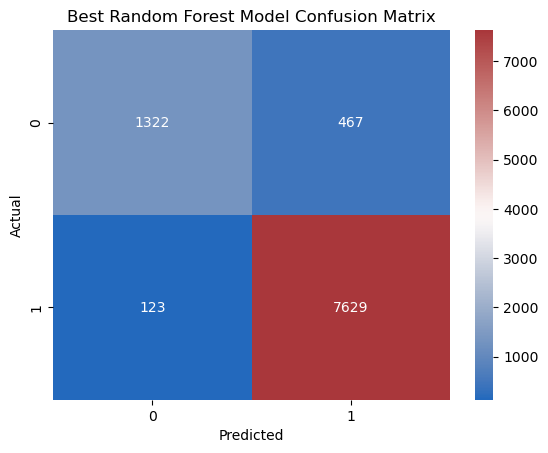

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_fitted_grid.predict(X_test), labels=rf_fitted_grid.best_estimator_.classes_)

# Set the font color of values inside the matrix to white
sns.heatmap(cm, annot=True, cmap='vlag', fmt='d', annot_kws={"color": "white"})


plt.title("Best Random Forest Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [23]:
#Negative Predictive Value = TN / (TN + FN)
print(f"Negative Predictive Value: {1322 /(1322 + 123)}")

#True Negative Ratio = TN / (TN + FP)
print(f"True Negative ratio: {1322 / (1322 + 467)}")


Negative Predictive Value: 0.914878892733564
True Negative ratio: 0.7389603130240358


In [24]:
# Predicted probabilities from the fitted grid search
y_pred_prob = rf_fitted_grid.predict_proba(X_test)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagonal line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='ROC Curve: Random Forest',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='Recall'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()

The model is performing well in terms of classifying instances, with a high true positive rate and a low false positive rate.

This could be a reliable classification model

The classification of the negative cases is not bad, but tends to label most cases as churn (due to the imbalance target variable), which affects the true negative ratio. The lowest score 0.738


## XGBoost

|  Name |Comments   |Accuracy / recall   |Parameters|
|---|---|---|---|
| Version 1: |Significantly less overfitting compared to the random forest, the model selected the upper bound of layers |accuracy: 0.94/0.98|Selected parameters: scale_pos_weight': 1, reg_lambda': 0.5, n_estimators': 10, max_depth': 20, learning_rate': 0.1, gamma': 0.1, colsample_bytree': 0.8|
| Version 2 |Same result with less layers, it the accuracy is improved faster vs the random forest and is less expensive  |0.94/0.97|Selected parameters: scale_pos_weight': 1, reg_lambda': 0.5, reg_alpha': 1, n_estimators': 200, max_depth': 5, learning_rate': 1, gamma': 0.1, colsample_bytree': 0.9|

The results between  2  - 5 layers are very similar, and the decision of which model to choose, depend on which metrics to optimize, since the accuracy of 2 is slightly better but the specificity is not as good

After reviewing the pros and cons, I will continue with the XGBoost of 5 layers

> the next cell is commented due to the running time: since it isn't the final version, there is no pickle of the model

In [25]:

"""
estimators = [
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [5, 10, 20],
    'model__colsample_bytree': [0.3, 0.5, 0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.01, 0.1, 1],  # Hyperparameter for XGBoost
    'model__gamma':[0.01, 0.1, 1, 10],
    'model__n_estimators': [1, 10],
    'model__scale_pos_weight': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
xgb_fitted_grid = grid.fit(X_train, y_train)

"""

'\nestimators = [\n    ("model", XGBClassifier())\n]\n\npipe = Pipeline(estimators)\n\nparam_grid = { \n    \'model__max_depth\': [5, 10, 20],\n    \'model__colsample_bytree\': [0.3, 0.5, 0.8],  # Hyperparameter for XGBoost\n    \'model__reg_alpha\': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost\n    \'model__reg_lambda\': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost\n    \'model__learning_rate\': [0.01, 0.1, 1],  # Hyperparameter for XGBoost\n    \'model__gamma\':[0.01, 0.1, 1, 10],\n    \'model__n_estimators\': [1, 10],\n    \'model__scale_pos_weight\': [0.1, 1, 10, 100]\n}\n\ngrid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)\nxgb_fitted_grid = grid.fit(X_train, y_train)\n\n'

In [27]:
"""
#Version 1 best parameters
xgb_fitted_grid.best_params_ 
#Accuracy score
xgb_fitted_grid.score(X_test, y_test)
#Overfitting evaluation
xgb_fitted_grid.score(X_train, y_train)
"""

'\n#Version 1 best parameters\nxgb_fitted_grid.best_params_ \n#Accuracy score\nxgb_fitted_grid.score(X_test, y_test)\n#Overfitting evaluation\nxgb_fitted_grid.score(X_train, y_train)\n'

In [ ]:
"""#XGBoost version 1 results

# Predict labels
y_pred = xgb_fitted_grid.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = xgb_fitted_grid.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
)
"""


- Baseline accuracy: 0.9405722670579604
- Baseline recall: 0.9827141382868937
- Baseline precision: 0.9462178611352627
- Baseline f1: 0.9641207365690058



> the next cell is commented, but has the respective pickle

In [ ]:
"""
#XGBoost Version 2
estimators = [
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [5],
    'model__colsample_bytree': [ 0.9],  # Hyperparameter for XGBoost
    'model__reg_alpha': [1 ],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0.5],  # Hyperparameter for XGBoost
    'model__learning_rate': [1],  # Hyperparameter for XGBoost
    'model__gamma':[0.1,],
    'model__n_estimators': [100, 150, 200, 500],
    'model__scale_pos_weight': [1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
xgb_fitted_grid2 = grid.fit(X_train, y_train)
"""

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
#Saving the model:
#joblib.dump(xgb_fitted_grid2, '../model/it2_xgboost.pkl')

['../model/it2_xgboost.pkl']

In [28]:
#loading the model
xgb_fitted_grid2 = joblib.load('../model/it2_xgboost.pkl')

In [29]:
#Version 2 best parameters
print(xgb_fitted_grid2.best_params_)

{'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 0.5, 'model__scale_pos_weight': 1}


In [30]:
#Version 2 score
xgb_fitted_grid2.score(X_test, y_test)


0.9390001048108165

#### Optimizing the XGBoost

In [31]:
xgdepth = np.arange(1, 25)

> The next cell takes 3mins to run

In [32]:
#Split:

#Train and test split
X_train_tempxg, X_valxg, y_train_tempxg, y_valxg = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=24)

#Lists:

accuracy_testxg = []
accuracy_trainxg = []

recall_final = []

#Model: 
for depth in xgdepth:
    it2_xg = XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=1, max_depth=depth, n_estimators=200, reg_alpha=1, reg_lambda=0.05, scale_pos_weight=1)
    #it2_cv = cross_val_score(it2_rf, X_train, y_train, cv=5)
    it2_fitted = it2_xg.fit(X_train_tempxg, y_train_tempxg)
    accuracy_testxg.append(it2_fitted.score(X_valxg, y_valxg))
    accuracy_trainxg.append(it2_fitted.score(X_train_tempxg, y_train_tempxg))
    y_pred = it2_fitted.predict(X_valxg)
    recall_final.append(recall_score(y_valxg, y_pred))

In [33]:
fig = go.Figure()

# Accuracy test
fig.add_trace(go.Scatter(x=xgdepth, y=accuracy_testxg, name='Accuracy Test', line=dict(color='red')))

# Accuracy_train
fig.add_trace(go.Scatter(x=xgdepth, y=accuracy_trainxg, name='Accuracy Train', line=dict(color='slateblue')))

# Set the layout with titles
fig.update_layout(
    title='XGBoost overfitting: accuracy and depth',
    xaxis_title='Depths',
    yaxis_title='Accuracy',
    legend_title='Accuracy',
)

# Show the figure
fig.show()

The optimum number of layers is 2, after that depth the number starts to overfit and underperform, this would be the main decision driver if the most relevant metric was accuracy, but for the negative classes, a layer of 5 outperforms

In [34]:
#XGBoost Version 3
estimators = [
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [2],
    'model__colsample_bytree': [ 0.9],  # Hyperparameter for XGBoost
    'model__reg_alpha': [1 ],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0.5],  # Hyperparameter for XGBoost
    'model__learning_rate': [1],  # Hyperparameter for XGBoost
    'model__gamma':[0.1,],
    'model__n_estimators': [200],
    'model__scale_pos_weight': [1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
xgb_fitted_grid3 = grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


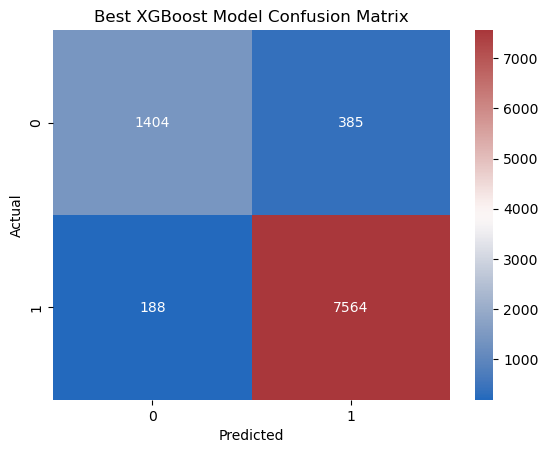

In [35]:
# Confusion Matrix
cmx = confusion_matrix(y_test, xgb_fitted_grid3.predict(X_test), labels=xgb_fitted_grid3.best_estimator_.classes_)

# Set the font color of values inside the matrix to white
sns.heatmap(cmx, annot=True, cmap='vlag', fmt='d', annot_kws={"color": "white"})


plt.title("Best XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [36]:
#Negative Predictive Value = TN / (TN + FN)
print(f"Negative Predictive Value: {1404 /(1404 + 188)}")

#True Negative Ratio = TN / (TN + FP)
print(f"True Negative ratio: {1404 / (1404 + 385)}")

Negative Predictive Value: 0.8819095477386935
True Negative ratio: 0.7847959754052544


In [37]:
#XGBoost version 3 results

# Predict labels
y_pred = xgb_fitted_grid3.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = xgb_fitted_grid3.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.9399434021591028
- Baseline recall: 0.9757481940144479
- Baseline precision: 0.951566234746509
- Baseline f1: 0.9635055092032355



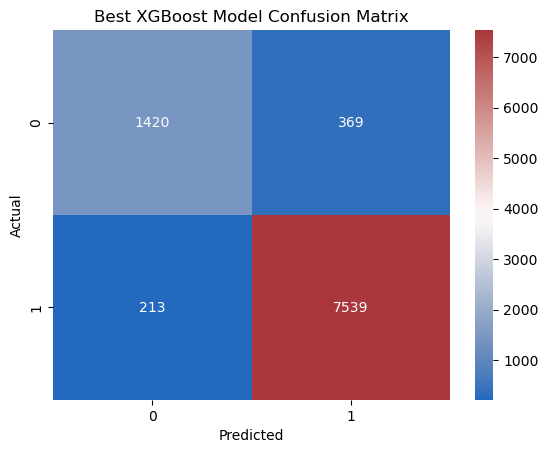

In [39]:
# Confusion Matrix
cmx = confusion_matrix(y_test, xgb_fitted_grid2.predict(X_test), labels=xgb_fitted_grid2.best_estimator_.classes_)

# Set the font color of values inside the matrix to white
sns.heatmap(cmx, annot=True, cmap='vlag', fmt='d', annot_kws={"color": "white"})


plt.title("Best XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [40]:
#Negative Predictive Value = TN / (TN + FN)
print(f"Negative Predictive Value: {1356 /(1356 + 134)}")

#True Negative Ratio = TN / (TN + FP)
print(f"True Negative ratio: {1356 / (1356 + 433)}")

Negative Predictive Value: 0.9100671140939597
True Negative ratio: 0.7579653437674678


In [41]:
#XGBooster version 3 accuracy
xgb_fitted_grid3.score(X_test, y_test)

0.9399434021591028

In [42]:
#ROC XGB version 2 (selected version)
# Predicted probabilities from the fitted grid search
y_pred_prob = xgb_fitted_grid2.predict_proba(X_test)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagonal line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='ROC Curve XGBoost: 0.97 ',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='Recall'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()

----

## Iteration 1 

- The results of these models is affected by data leakage, it was caused during the pre-processing notebook when I performed the scaling
- Overall, the best model has been Random Forest, I will continue with this algorithm for the final results, tunning and running it again without data leakage
- The best iteration of the Random Forest had an accuracy of 96, recall of 97 and precision of 98. Summarized in a ROC AUC of 98 and F1 of 97
    - Parameters: Standard Scaler, no PCA and max depth = 100, cross - validation = 3

**Algorithms**

- In the evaluation for the final model, careful consideration was given to weighting precision, recall, overfitting, the number of parameters, and runtime, leading to the decision to continue with the random forest algorithm.


KNN

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      | different number of neighbors       |0.81        |underperform vs baseline, and used the maximum number of neighbors       |
| 2   | Increased neighbors to a range 200        |0.84        |Accuracy increased, but continued to underperform. Also used the maximum number of neighbors        |
| 3   | Increased the number of neighbors to a 1000 range        |0.84        |The number of neighbors stayed on the lower bound. Optimum number ≈ 200       |
| 4   | Weight by distance        |0.91        |Significant improvement. Accuracy surpasses the baseline        |

- The KNN algorithm proved ineffective in finding meaningful patterns and exhibited slow fitting times due to the large number of features. However, a significant increase in accuracy was observed upon switching to the 'distance' metric, which assigns weights to points based on the inverse of their distance.
- The presence of irrelevant features in the dataset, coupled with the default weight that treats all features equally, introduces unnecessary noise into the calculations.
- Considering the number of features and datapoints, it is evident that this model is not efficient for predicting churn.


----------------------------------------------------------------------

Random Forest

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      |Max depth 10       |0.9 / 0.9 |No normalize and Standard Scaler, CV = 3. It used the upper bound of neighbors|
| 2   | Max depth increased range 10 - 20        |0.96 / 0.94 |The model used the upper bound|
| 3   | Max depth increased range 20 - 100        |0.96 / 0.95|The model used the upper bound|
| 4   | Max depth increased range 100 - 500        |0.97 / 0.96|100 maximum depth. The optimum parameter is ≈ 100|

- All iterations exceeded the baseline performance, and the models demonstrated significantly reduced processing time compared to KNN.
- The optimized maximum depth is approximately 100 levels; however, beyond 20 levels, diminishing marginal returns become evident.

----------------------------------------------------------------------

XGBoost

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      | Random Search 1: 20 iterations, cv 3       |accuracy 0.80       |scale pos weight 1, reg lambda 0.5, 100 estimators, max depth 3 (upper bound), learning rate 0.1, gamma 0.0001, cols sample by tree 0.8|
| 2   | Random search 2: 50 iterations, cv 3        |accuracy 0.81        |n components 0.9, scale pos weight 1, reg lambda 5, 100 estimators, max depth 1, learning rate 0.1, gamma 1, cols sample by tree 0.5|
| 3   | GridSearch 1        |Accuracy 0.84        |col sample by tree 0.8, gamma 0.0001, learning rate 0.01, max depth 4 (upper bound), n estimators 200, reg alpha 1, scale pos weight 1, no n components       |
| 4   | GridSearch 2 Range depth 4 - 15       |0.95 / 0.94        |15 max depth (upper bound), all the other parameters stayed the same   |
| 5   | GridSearch 3   Range depth 15 - 100     |0.95 / 0.94        |15 max depth (lower bound), all the other parameters stayed the same        |

- Given the extensive parameter set requiring optimization, I initiated the process with Random Search iterations to narrow down the parameter ranges.
- The optimized models outperformed the baseline accuracy.
- A random sample of 0.8 was utilized to introduce greater diversity in the trees, complemented by a small learning rate as the number of iterations was not a limiting factor. A low gamma value was chosen to account for the depth of the trees. Additionally, the scale positive weight was set to 1 due to the implementation of the SMOTE transformation.


### Uploading the files

In [ ]:
#Uploading the files
def initial_sets():
    X_train_sm_ss = pd.read_csv('../Data/elenas-it1-x_train_sm_ss.csv', index_col=0)
    X_test_ss_sm = pd.read_csv('../Data/elenas-it1-x_test_sm_ss.csv', index_col=0)
    y_train_sm = pd.read_csv('../Data/elenas-it1-y_train_sm2.csv', index_col=0)
    y_test = pd.read_csv('../Data/elenas-it1-y_test.csv', index_col=0)
    #y_test = y_test["order_last_month"]
    #y_train_sm = y_train_sm["order_last_month"]
    return X_train_sm_ss, X_test_ss_sm, y_train_sm, y_test

In [ ]:
#Defining the variables
X_train, X_test, y_train, y_test = initial_sets()

#Sanity check:
print(f"""
     X_train_sm_ss: {X_train.shape}
     X_test_ss_sm: {X_test.shape}
     y_train_sm: {y_train.shape}
     y_test: {y_test.shape}
      """)



     X_train_sm_ss: (377132, 28)
     X_test_ss_sm: (52623, 28)
     y_train_sm: (377132, 1)
     y_test: (52623, 1)
      


### KNN


- The KNN algorithm proved ineffective in finding meaningful patterns and exhibited slow fitting times due to the large number of features. However, a significant increase in accuracy was observed upon switching to the 'distance' metric, which assigns weights to points based on the inverse of their distance.
- The presence of irrelevant features in the dataset, coupled with the default weight that treats all features equally, introduces unnecessary noise into the calculations.
- Considering the number of features and datapoints, it is evident that this model is not efficient for predicting churn.

Iteration for KNN -> ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.


> I commented out the cell due to runtime issues. Since it wasn't the final KNN model, there is no need for pickling

In [ ]:
"""
#KNN gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", KNeighborsClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'normalise': [None],
        'model__n_neighbors': [200, 500, 1000],
        'select':  [None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
knn_fitted_grid = grid.fit(X_train, y_train)
"""


In [ ]:
"""
#Distance based Search Grid
#KNN  distance adjusted gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", KNeighborsClassifier(weights=('distance')))
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [KNeighborsClassifier(weights=('distance'))],
        'normalise': [None],
        'model__n_neighbors': [50, 100, 200],
        'select':  [None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
distance_knn_fitted_grid = grid.fit(X_train, y_train)
"""

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A col

### Random Forest:

Version 1:
- {'model': RandomForestClassifier(max_depth=10), 'model__max_depth': 10, 'normalise': None, 'select': None}
- Precision: 0.97
- Recall: 0.909
- F1 score: 0.94
- accuracy 90


Version 2:
- {'model': RandomForestClassifier(max_depth=20), 'model__max_depth': 20, 'normalise': None, 'select': None}
- Precision: accuracy of churn predictions: 0.980
- Recall: 0.96
- F1 score: 0.970
- Accuracy 0.947


Version 3:
- {'model': RandomForestClassifier(max_depth=100), 'model__max_depth': 100, 'normalise': None, 'select': None}
- Precision: 0.98
- Recall: 0.96
- F1 score: 0.97
- Accuracy: 0.958

Version 4:
- {'model': RandomForestClassifier(max_depth=100), 'model__max_depth': 100, 'normalise': None, 'select': None}
- Precision: 0.98
- Recall: 0.97
- F1 score: 0.97
- accuracy: 0.95





> I commented out the cell due to runtime issues. Since it wasn't the final RF model, there is no need for pickling

In [ ]:
"""#Random Forest gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", RandomForestClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [RandomForestClassifier()],
        'normalise': [None],
        'model__max_depth': [100, 500, 800,],
        'select':  [PCA(n_components=0.9), None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
rf_fitted_grid = grid.fit(X_train, y_train)
"""

### XGBoost:

Due to the number of hyperparameters of the XGBoost, I decided to start narrowing down the options with random grids and then conduct a final gridsearch

Random search 1
    Parameters: n_components': None, scale_pos_weight': 1, reg_lambda': 0.5, reg_alpha': 1, n_estimators': 100, max_depth': 3, learning_rate': 0.1, gamma': 0.0001, colsample_bytree': 0.8

Random search 2:
    Parameters: n_components': 0.9, scale_pos_weight': 1, reg_lambda': 5,reg_alpha': 0, n_estimators': 100, max_depth': 1, learning_rate': 0.1, gamma': 1, colsample_bytree': 0.5


Non Random 3:
    Parameters: colsample_bytree: 0.8, gamma: 0.0001, learning_rate: 0.01, max_depth: 4, n_estimators: 200, reg_alpha: 1, reg_lambda': 1, scale_pos_weight': 1, n_components': None
- accuracy 0.838

Non Random 4: 
    Parameters: colsample_bytree: 0.8, gamma: 0.0001, learning_rate: 0.01, max_depth: 15, n_estimators: 200, reg_alpha: 1, reg_lambda: 1, scale_pos_weight: 1, n_components: None
- Accuracy: 0.94

Non Random 5:
    Parameters: colsample_bytree: 0.8, gamma: 0.0001, learning_rate: 0.01,  max_depth: 15, n_estimators: 200, reg_alpha: 1, reg_lambda: 1, scale_pos_weight: 1, n_components': None
- Accuracy 0.94
- Precision: 0.974
- Recall: 0.959
- F1 score: 0.966


> I commented out the cell due to runtime issues. Since it wasn't the final RF model, there is no need for pickling

In [ ]:
"""X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("select", PCA()),
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [1, 2, 3],
    'select__n_components': [0.9, None],  # Hyperparameter for PCA
    'model__colsample_bytree': [0.3, 0.5, 0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],  # Hyperparameter for XGBoost
    'model__gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10],
    'model__n_estimators': [1, 10, 100],
    'model__scale_pos_weight': [0.001, 0.1, 1, 10, 100]
}

grid = RandomizedSearchCV(pipe, param_grid, cv=3, verbose=1, refit='accuracy', n_iter=70)
xgb_fitted_grid = grid.fit(X_train, y_train)
"""

> I commented out the cell due to runtime issues. Since it wasn't the final RF model, there is no need for pickling

In [ ]:
"""#Search grid (non random)
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("select", PCA()),
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [15, 50, 100],
    'select__n_components': [None],  # Hyperparameter for PCA
    'model__colsample_bytree': [0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [1],  # Hyperparameter for XGBoost
    'model__reg_lambda': [1],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.01],  # Hyperparameter for XGBoost
    'model__gamma':[0.0001],
    'model__n_estimators': [200],
    'model__scale_pos_weight': [1]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1, refit='accuracy')
non_rando_mxgb_fitted_grid = grid.fit(X_train, y_train)
"""